# C1 - Introduction to Human and Computer Vision
## Week 4

In [1]:
import os
import re
import matplotlib.pyplot as plt
import cv2
import pickle
import numpy as np

# Get project's root directory
BASE_PATH = os.path.join(re.search(r'.+(Team5)', os.getcwd())[0], 'week4')
os.chdir(BASE_PATH)
BASE_PATH

DATA_DIRECTORY = '../data'

In [2]:
# Read pickle file to see detailed info of the images augmentation
with open(f'{DATA_DIRECTORY}/qsd1_w4/augmentations.pkl', 'rb') as f:
    augmentations_info = pickle.load(f)

### a) Remove background, detect noise (and filter it)

In [3]:
from src.background_removal import background_removal
from src.noise_removal import denoise_image
from tqdm import tqdm

# Image names
QSD1_w4_names = [f for f in os.listdir(f'{DATA_DIRECTORY}/qsd1_w4/') if f.endswith('.jpg')]
QSD1_w4_names.sort()

# Initialize datasets
BBDD = []
QSD1_w4 = []
QSD1_w4_filtered = []
QSD1_w4_nonAugmented = []

# Load datasets (+ filter)
for image_name in tqdm(QSD1_w4_names):
    # Read QSD1_w4
    image_bgr = cv2.imread(f'{DATA_DIRECTORY}/qsd1_w4/{image_name}')
    image_qsd1 = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    QSD1_w4.append(image_qsd1)

    # Read non-augmented image
    image_bgr = cv2.imread(f'{DATA_DIRECTORY}/qsd1_w4/non_augmented/{image_name}')
    image_nonAugmented = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    image_nonAug_bckg_remov = background_removal(image_nonAugmented)  # Remove background in non-augmented image
   
    QSD1_w4_nonAugmented.append(image_nonAug_bckg_remov)

    # Filter image from QSD1_w4
    filtered_image = background_removal(denoise_image(image_qsd1))  # Detect noise (and clean it) + Remove background

    QSD1_w4_filtered.append(filtered_image)

100%|██████████| 30/30 [01:23<00:00,  2.79s/it]


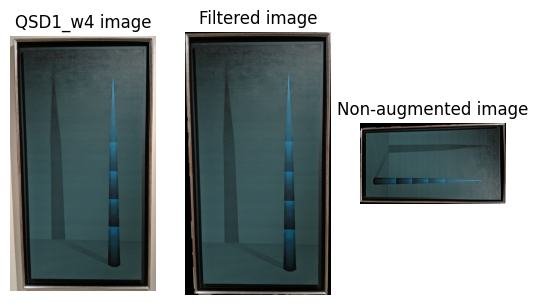

In [ ]:
# Plot some examples
img_number = 0


fig, axes = plt.subplots(1, 3)  # 1 fila, 3 columnas

# QSD1_w4 image
axes[0].imshow(QSD1_w4[img_number])
axes[0].set_title('QSD1_w4 image')
axes[0].axis('Off')

# Filtered image (background removal + denoise)
axes[1].imshow(QSD1_w4_filtered[img_number][0])
axes[1].set_title('Filtered image')
axes[1].axis('Off')

# Non-augmented image
axes[2].imshow(QSD1_w4_nonAugmented[img_number][0])
axes[2].set_title('Non-augmented image')
axes[2].axis('Off')

plt.show()
plt.close()

### b) Detect keypoints and compute descriptors

#### HOG

In [30]:
from skimage.feature import hog
from skimage import exposure
from scipy.spatial.distance import euclidean

params={
    'shape': (256,256),  # Shape we want to resize the image to
    'pixels_per_cell': (8,8),
    'cells_per_block': (2,2),
}

def hog_descriptor(image, shape: tuple, pixels_per_cell: tuple, cells_per_block: tuple):
    # Image to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize image (we need same dimensions in all the image descriptros to compare)
    image = cv2.resize(image, shape)

    # Compute HOG
    hog_descriptor, hog_image = hog(image, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True)
    
    # Rescale intensity, otherwise we may see everyhing black
    hog_image = exposure.rescale_intensity(hog_image, in_range=(0, np.max(hog_image)/10))

    return hog_descriptor, hog_image


In [31]:
hog_query = []
for picture in tqdm(QSD1_w4_filtered):
    for painting in picture:
        des, image = hog_descriptor(painting, **params)
        hog_query.append({'descriptor': des, 'image': image})


hog_bd = []
for picture in tqdm(QSD1_w4_nonAugmented):
    for painting in picture:
        des, image = hog_descriptor(painting, **params)
        hog_bd.append({'descriptor': des, 'image': image})

100%|██████████| 30/30 [00:02<00:00, 14.70it/s]


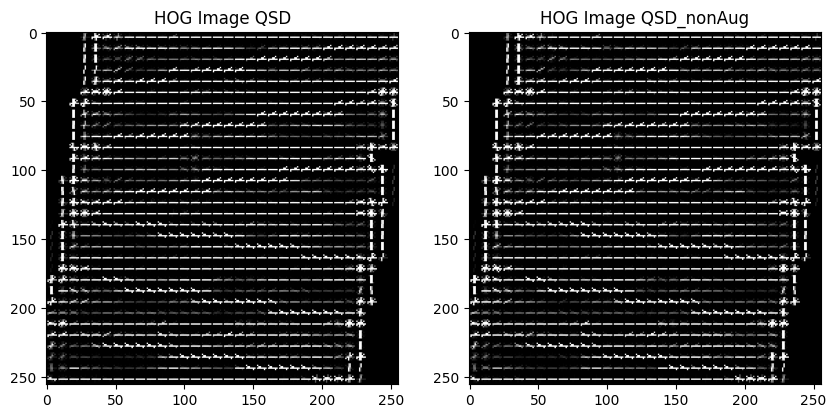

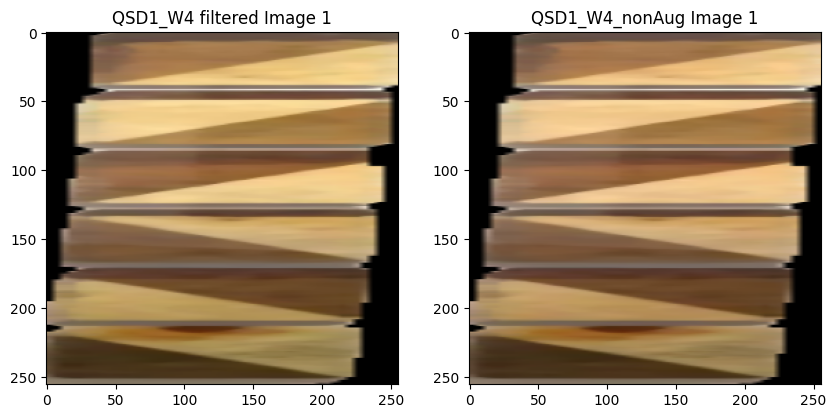

In [76]:
img_num = 1

# Plot HOG images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(hog_query[img_num]['image'], cmap='gray')
ax1.set_title('HOG Image QSD')
ax2.imshow(hog_bd[img_num]['image'], cmap='gray')
ax2.set_title('HOG Image QSD_nonAug')
plt.show()

# Plot orignal images (filtered and non-augmented)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(cv2.resize(QSD1_w4_filtered[img_num][0], params['shape']), cmap='gray')
ax1.set_title(f'QSD1_W4 filtered Image {img_num}')
ax2.imshow(cv2.resize(QSD1_w4_nonAugmented[img_num][0], params['shape']), cmap='gray')
ax2.set_title(f'QSD1_W4_nonAug Image {img_num}')
plt.show()

In [26]:
# Calcular la distancia entre los descriptores HOG
def find_k_nearest_neighbors(hog_query, hog_bd, k=5):
    k_nearest_neighbors = []
    
    for query in hog_query:
        query_descriptor = query['descriptor']
        distances = []
        
        # Calcula la distancia entre el descriptor de consulta y cada descriptor en hog_bd
        for i, bd_entry in enumerate(hog_bd):
            bd_descriptor = bd_entry['descriptor']
            distance = euclidean(query_descriptor, bd_descriptor)
            distances.append((distance, i))
        
        # Ordena las distancias y selecciona los k más cercanos
        distances.sort()  # Ordena por la primera posición de la tupla (la distancia)
        nearest_neighbors = [idx for _, idx in distances[:k]]
        
        # Agrega los k vecinos más cercanos a la lista de resultados
        k_nearest_neighbors.append(nearest_neighbors)
    
    return k_nearest_neighbors


In [ ]:
k = 5 
nearest_neighbors = find_k_nearest_neighbors(hog_query, hog_bd, k)

In [62]:
img_num = 3
#hog_query[img_num]['image'].shape
hog_bd[img_num]['image'].shape

(256, 256)